In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

## Week 11A: Supervised Learning with Scikit-Learn
Nov 10, 2020


## Housekeeping

- [Assignment #6](https://github.com/MUSA-550-Fall-2020/assignment-6) due 11/19
- Assignment #7 will be posted on 11/19
    — Includes final project proposal
    - Machine learning analysis of Philadelphia housing sales
    - Due Thursday Dec 3 (in two weeks)

## Last week

- A crash course on clustering 
    - non-spatial: k-means
    - spatial: DBSCAN
- An introduction to scikit-learn

## Where we left off: Extending DBSCAN beyond just spatial coordinates

DBSCAN can perform high-density clusters from more than just spatial coordinates, as long as they are properly normalized

In [3]:
from sklearn.cluster import dbscan
from sklearn.preprocessing import StandardScaler

## Exercise: Extracting patterns from NYC taxi rides

I've extracted data for taxi pickups or drop offs occurring in the Williamsburg neighborhood of NYC from the NYC taxi open data. 

Includes data for: 
- Pickup/dropoff location
- Fare amount
- Trip distance
- Pickup/dropoff hour

**Goal:** identify clusters of similar taxi rides that are not only clustered spatially, but also clustered for features like hour of day and trip distance

Inspired by [this CARTO blog post](https://carto.com/blog/using-location-data-identify-communities-williamsburg-ny/)

## Step 1: Load the data

In [4]:
taxi = pd.read_csv("./data/williamsburg_taxi_trips.csv")
taxi.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-01-15 19:05:41   2015-01-15 19:20:22                2           7.13   
1  2015-01-15 19:05:44   2015-01-15 19:17:44                1           2.92   
2  2015-01-25 00:13:06   2015-01-25 00:34:32                1           3.05   
3  2015-01-26 12:41:15   2015-01-26 12:59:22                1           8.10   
4  2015-01-20 22:49:11   2015-01-20 22:58:46                1           3.50   

    pickup_x   pickup_y  dropoff_x  dropoff_y  fare_amount  tip_amount  \
0 -8223667.0  4979065.0 -8232341.0  4970922.0         21.5        4.50   
1 -8237459.0  4971133.5 -8232725.0  4970482.5         12.5        2.70   
2 -8236711.5  4972170.5 -8232267.0  4970362.0         16.5        5.34   
3 -8222485.5  4978445.5 -8233442.5  4969903.5         24.5        5.05   
4 -8236294.5  4970916.5 -8231820.5  4971722.0         12.5        2.00   

   dropoff_hour  pickup_hour  
0            19           19  
1            19           19  
2             0            0  
3            12           12  
4            22           22

## Step 2: Extract and normalize several features

We will focus on the following columns:
- `pickup_x` and `pickup_y`
- `dropoff_x` and `dropoff_y`
- `trip_distance`
- `pickup_hour`

Use the `StandardScaler` to normalize these features.

In [5]:
feature_columns = [
    "pickup_x",
    "pickup_y",
    "dropoff_x",
    "dropoff_y",
    "trip_distance",
    "pickup_hour",
]
features = taxi[feature_columns].copy() 

In [6]:
features.head()

pickup_x   pickup_y  dropoff_x  dropoff_y  trip_distance  pickup_hour
0 -8223667.0  4979065.0 -8232341.0  4970922.0           7.13           19
1 -8237459.0  4971133.5 -8232725.0  4970482.5           2.92           19
2 -8236711.5  4972170.5 -8232267.0  4970362.0           3.05            0
3 -8222485.5  4978445.5 -8233442.5  4969903.5           8.10           12
4 -8236294.5  4970916.5 -8231820.5  4971722.0           3.50           22

In [7]:
# Scale these features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
 
scaled_features

array([[ 3.35254171e+00,  2.18196697e+00,  8.59345108e-02,
         1.89871932e-01, -2.58698769e-03,  8.16908067e-01],
       [-9.37728802e-01, -4.08167622e-01, -9.76176333e-02,
        -9.77141849e-03, -2.81690985e-03,  8.16908067e-01],
       [-7.05204353e-01, -6.95217705e-02,  1.21306539e-01,
        -6.45086739e-02, -2.80981012e-03, -1.32713022e+00],
       ...,
       [-1.32952083e+00, -1.14848599e+00, -3.37095821e-01,
        -1.09933782e-01, -2.76011198e-03,  7.04063946e-01],
       [-7.52953521e-01, -7.01094651e-01, -2.61571762e-01,
        -3.00037860e-01, -2.84530879e-03,  7.04063946e-01],
       [-3.97090015e-01, -1.71084059e-02, -1.11647543e+00,
         2.84810408e-01, -2.93269014e-03,  8.16908067e-01]])

In [8]:
print(scaled_features.shape)
print(features.shape)

(223722, 6)
(223722, 6)


## Step 3: Run DBSCAN to extract high-density clusters

- We want the highest density clusters, ideally no more than about 30-50 clusters.
- Run the DBSCAN and experiment with different values of `eps` and `min_samples`
    - I started with `eps` of 0.25 and `min_samples` of 50 

- Add the labels to the original data frame and calculate the number of clusters. It should be less than 50 or so. 
    
**Hint:** If the algorithm is taking a long time to run (more than a few minutes), the `eps` is probably too big!

In [9]:
# Run DBSCAN 
cores, labels = dbscan(scaled_features, eps=0.25, min_samples=50)

# Add the labels back to the original (unscaled) dataset
features['label'] = labels

In [10]:
# Extract the number of clusters 
num_clusters = features['label'].nunique() - 1
print(num_clusters)

27


## Step 4: Identify the 5 largest clusters

Group by the label, calculate and sort the sizes to find the label numbers of the top 5 largest clusters

In [11]:
# Get cluster sizes, from largest to smallest
N = features.groupby('label').size().sort_values(ascending=False)
print(N)

label
-1     101292
 1      50673
 2      33277
 3      24360
 0       4481
 6       2270
 5       2215
 7       1459
 4        912
 9        519
 11       414
 8        254
 12       224
 13       211
 10       183
 17       143
 14       116
 23        97
 20        86
 16        85
 18        76
 15        70
 19        69
 24        52
 22        51
 21        49
 26        43
 25        41
dtype: int64


In [12]:
# Extract labels (ignoring label -1 for noise)
top5 = list(N.iloc[1:6].index)
print(top5)

[1, 2, 3, 0, 6]


## Step 5: Get mean statistics for the top 5 largest clusters

To better identify trends in the top 5 clusters, calculate the mean trip distance and pickup_hour for each of the clusters.

In [13]:
# get the features for the top 5 labels
selection = features['label'].isin(top5)

# select top 5 and groupby by the label
grps = features.loc[selection].groupby('label')

# calculate average pickup hour and trip distance per cluster
avg_values = grps[['pickup_hour', 'trip_distance']].mean()

avg_values.loc[top5]

pickup_hour  trip_distance
label                            
1        20.127405       4.025859
2         1.699943       3.915581
3         9.536905       1.175154
0        18.599643       7.508730
6         1.494714       2.620546

## Step 6a: Visualize the top 5 largest clusters

Now visualize the top 5 largest clusters:
- plot the dropoffs and pickups (same color) for the 5 largest clusters
- include the "noise" samples, shown in gray
      

**Hints:**
- For a given cluster, plot the dropoffs and pickups with the same color so we can visualize patterns in the taxi trips
- A good color scheme for a black background is given below

In [14]:
# a good color scheme for a black background
colors = ['aqua', 'lime', 'red', 'fuchsia', 'yellow']

In [15]:
# EXAMPLE: enumerating a list
example_list = [10, 12, 5, 13, 40]

for i, label_num in enumerate(example_list):
    print(f"i = {i}")
    print(f"label_num = {label_num}")

i = 0
label_num = 10
i = 1
label_num = 12
i = 2
label_num = 5
i = 3
label_num = 13
i = 4
label_num = 40


Plotting cluster #1...
Plotting cluster #2...
Plotting cluster #3...
Plotting cluster #0...
Plotting cluster #6...


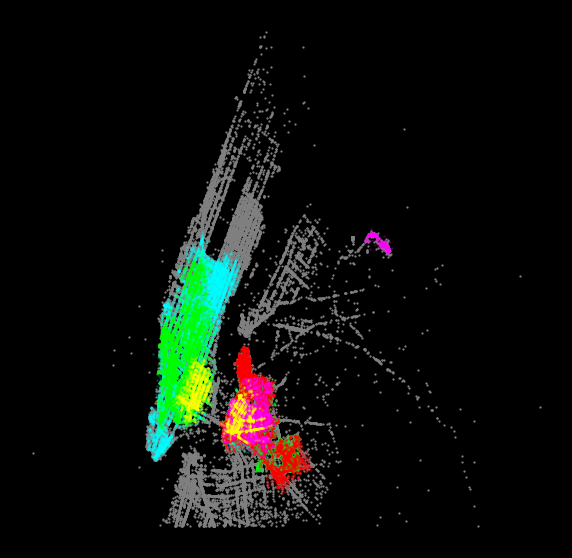

In [16]:
# Setup figure and axis
f, ax = plt.subplots(figsize=(10, 10), facecolor="black")

# Plot noise in grey
noise = features.loc[features["label"] == -1]
ax.scatter(noise["pickup_x"], noise["pickup_y"], c="grey", s=5, linewidth=0)

# specify colors for each of the top 5 clusters
colors = ["aqua", "lime", "red", "fuchsia", "yellow"]

# loop over top 5 largest clusters
for i, label_num in enumerate(top5):
    print(f"Plotting cluster #{label_num}...")

    # select all the samples with label equals "label_num"
    this_cluster = features.loc[features["label"] == label_num]

    # plot pickups
    ax.scatter(
        this_cluster["pickup_x"],
        this_cluster["pickup_y"],
        linewidth=0,
        color=colors[i],
        s=5,
        alpha=0.3,
    )

    # plot dropoffs
    ax.scatter(
        this_cluster["dropoff_x"],
        this_cluster["dropoff_y"],
        linewidth=0,
        color=colors[i],
        s=5,
        alpha=0.3,
    )

# Display the figure
ax.set_axis_off()

## Step 6b: Visualizing one cluster at a time

Another good way to visualize the results is to explore the other clusters one at a time, plotting both the pickups and dropoffs to identify the trends.  

Use different colors for pickups/dropoffs to easily identify them.

Make it a function so we can repeat it easily:

In [17]:
def plot_taxi_cluster(label_num):
    """
    Plot the pickups and dropoffs for the input cluster label
    """
    # Setup figure and axis
    f, ax = plt.subplots(figsize=(10, 10), facecolor="black")

    # Plot noise in grey
    noise = features.loc[features["label"] == -1]
    ax.scatter(noise["pickup_x"], noise["pickup_y"], c="grey", s=5, linewidth=0)

    # Get the features for "label_num"
    this_cluster = features.loc[features["label"] == label_num]

    # Plot pickups in fuchsia
    ax.scatter(
        this_cluster["pickup_x"],
        this_cluster["pickup_y"],
        linewidth=0,
        color="fuchsia",
        s=5,
        alpha=0.3,
    )

    # Plot dropoffs in aqua
    ax.scatter(
        this_cluster["dropoff_x"],
        this_cluster["dropoff_y"],
        linewidth=0,
        color="aqua",
        s=5,
        alpha=0.3,
    )

    # Display the figure
    ax.set_axis_off()

    # Add a label
    ax.text(
        0.1,
        0.9,
        f"Cluster #{label_num}",
        ha="left",
        color="white",
        weight='bold',
        fontsize=30,
        transform=ax.transAxes,
    )

In [18]:
top5

[1, 2, 3, 0, 6]

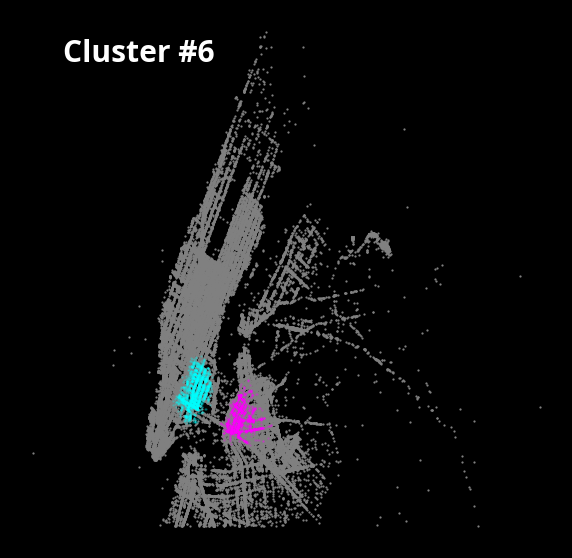

In [19]:
# Plot pickups (fuchsia) and dropoffs (aqua) for a specific cluster
plot_taxi_cluster(label_num=6) 

## Interpreting clustering results: the perils of algorithms

- Algorithms are made by humans and thus contain the biases of humans
- Clustering relies on the analyst to interpret the algorithm results and assign meaning to the different groups
- Clustering and similar techniques are often used by companies to identify certain groups of customers and target their products accordingly
- Location data is particularly good for micro-targeting, and thus, has especially important privacy concerns

## Algorithmic bias

An example from the CARTO analysis:

> We wanted to explore how we can use data to better understand and define communities of people, going beyond spatial borders like zip code and neighborhood boundaries.

However, their clusters include groupings by class and religion...e.g, "working class" and "Orthodox Jewish" residents. While the intention of this analysis may have been benign, the results could have easily been misused to target residents in a potentially discriminatory way.

We'll see more examples of algorithmic fairness on assignment #7 when modeling housing prices in Philadelphia.

#### Recommended readings
- [Discriminatory ads on Facebook](https://www.propublica.org/article/facebook-promises-to-bar-advertisers-from-targeting-ads-by-race-or-ethnicity-again)
- [NY Times exposé on the dangers of location data](https://www.nytimes.com/interactive/2019/12/19/opinion/location-tracking-cell-phone.html)

## Now onto new material...

## Reminder: clustering is an example of *unsupervised learning*

- Clustering tries to detect previously unknown structure in your input dataset
- Only requires the data set as input, no associated labels or prediction targets

## Today: an example of *supervised learning*


- **Key distinction**: requires a training data set as well as the desired solutions (called *labels*) as inputs to the algorithm
- Two main types:
    - **classification**: samples belong to two or more classes and we want to learn from already labeled data how to predict the class of unlabeled data. 
    - **regression**: predicting a continuous variable from a training dataset


<img src=attachment:1_ASYpFfDh7XnreU-ygqXonw.png width=800></img>
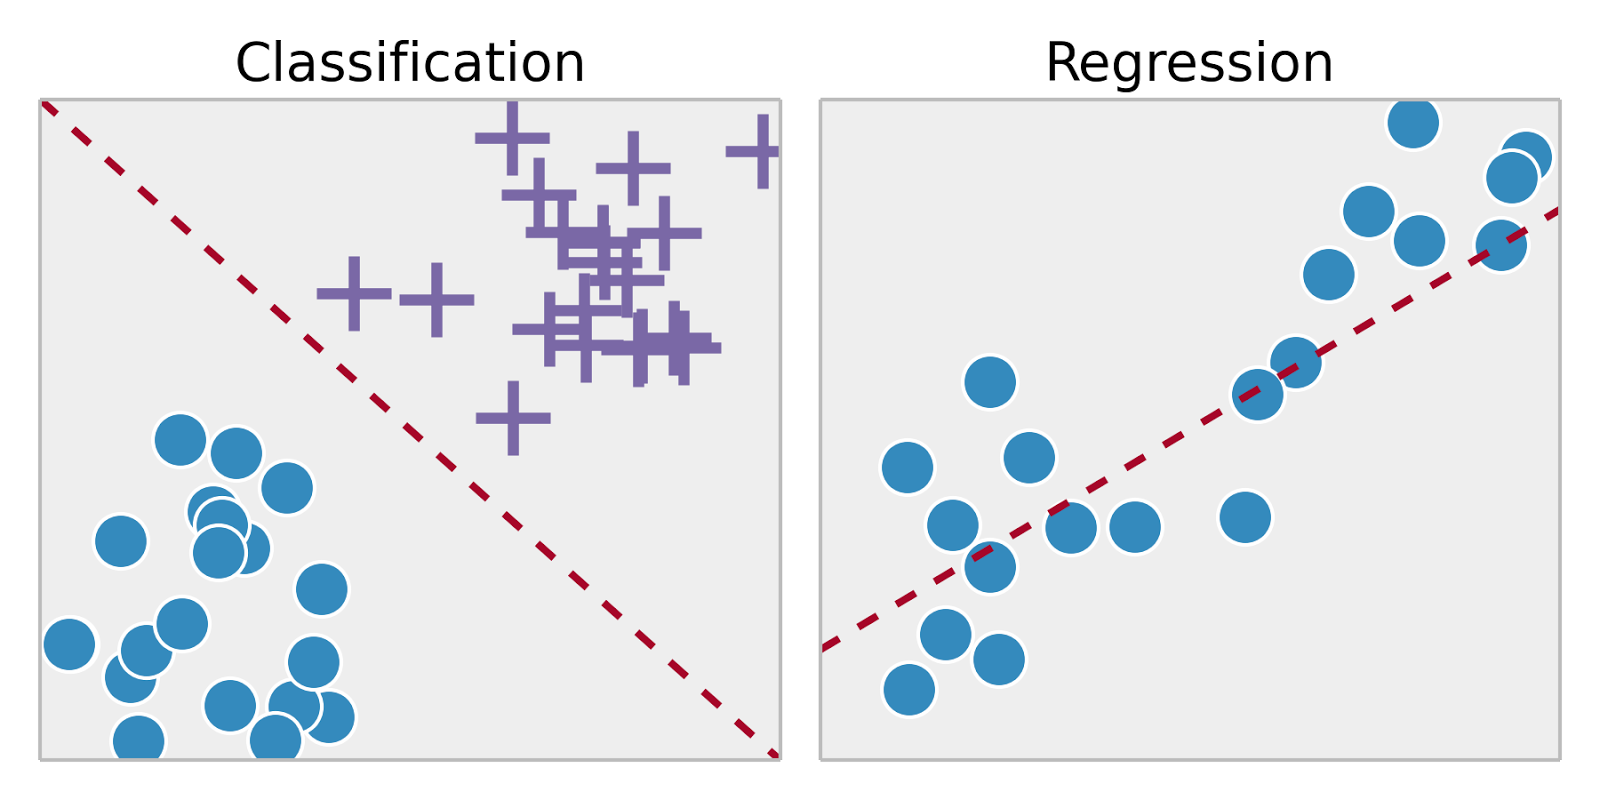

## Examples

- **classification**: a spam filter to classify new emails as spam / not spam based on past examples
- **regression**: predicting housing prices based on property characteristics

**Today, we'll walk through an end-to-end regression example to predict Philadelphia's housing prices** 

## Model-based learning

- Select a model that can represent the data 
- Use the training data to identify the best model parameters (by minimizing a *cost function*)
- Make predictions on new data — and hope that your model *generalizes* well to new data!


## Machine learning is really just an **optimization problem**

Given your training set of data, which model parameters best represent the observed data?

## 1. Choose a model

<img src=attachment:Screen%20Shot%202019-11-13%20at%207.13.05%20PM.png width=500></img>
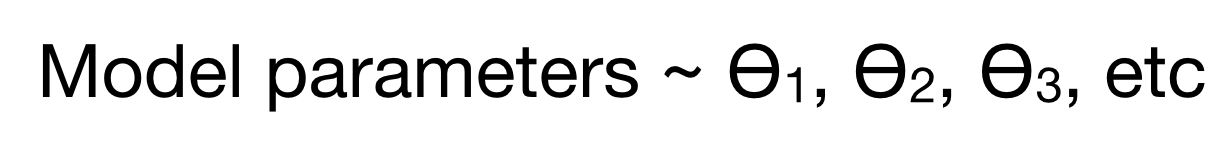

## 2. The model has an associated cost function

The *cost function* measures the difference between the model's predictions and the observed data

<img src=attachment:Screen%20Shot%202019-11-13%20at%207.19.30%20PM.png width=500></img>
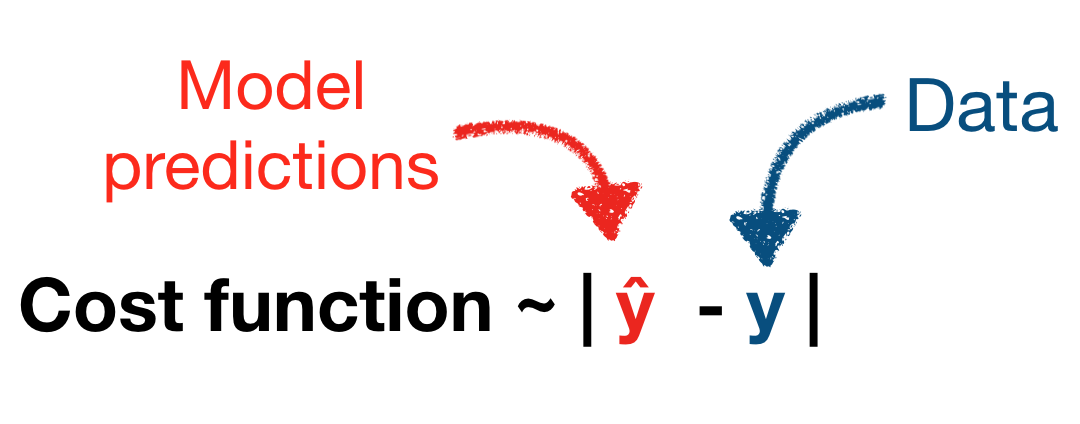

## 3. "Learn" the best model parameters

In scikit-learn, you will call the `fit()` method on your algorithm.

<img src=attachment:Screen%20Shot%202019-11-13%20at%207.29.15%20PM.png width=600></img>

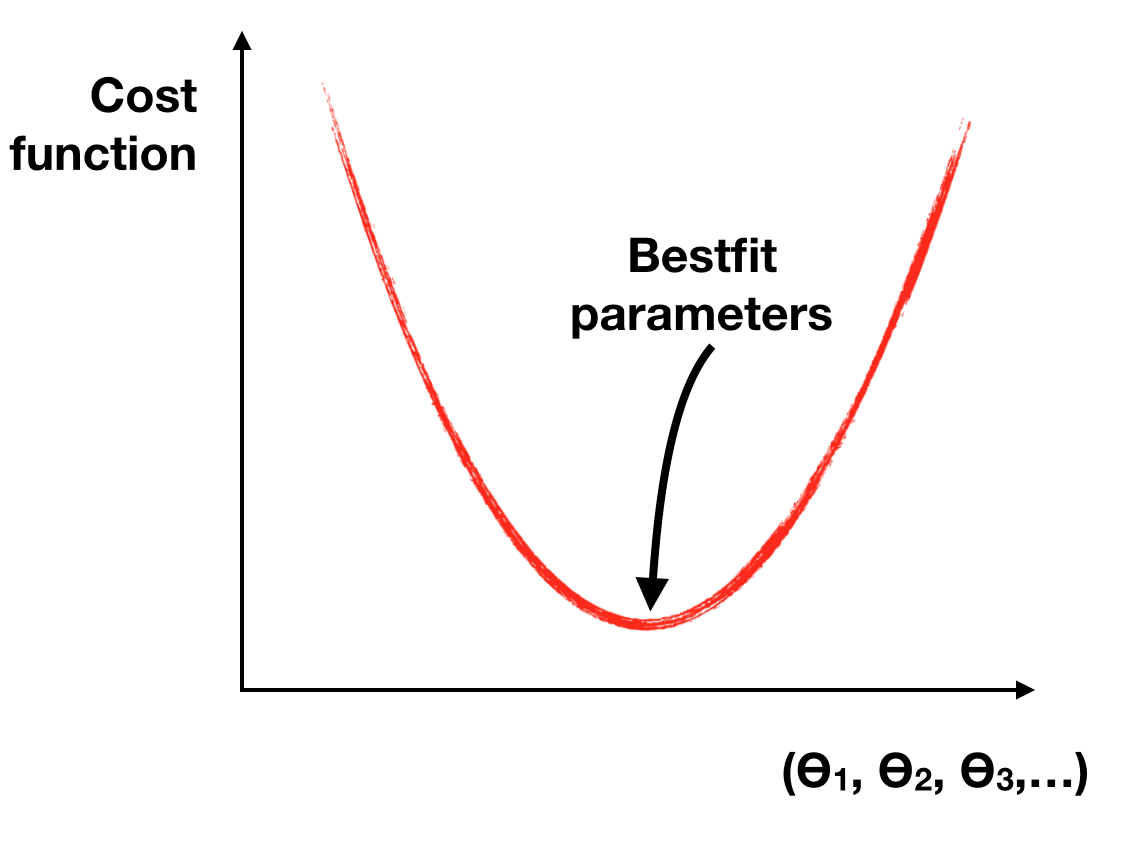

## Recap: the steps involved

1. Wrangle and understand data. 
1. Select a model that would be best for your dataset.
1. Train the model on the training data — the learning algorithm searches for the best model parameters
1. Apply the model to new data to make predictions.

**Key goal: how we can do this in a way to ensure the model is as generalizable as possible?**

## What could go wrong?


<img src=https://media.giphy.com/media/nDxjSaLT9gFig/giphy.gif width=600></img>

## Mistake #1: "bad data"

Or: "garbage in, garbage out" 

**Common issues:**

- Not enough training data
- Training data isn't representative of the unseen data that you want to make predictions for
- Poor quality data — errors, missing data, outliers
- Poor features in the training set
    - You'll often hear the phrase *feature engineering* to describe the process of improving your input dataset: 
    - Involves: feature selection, feature extraction, creating new features

## Mistake #2: "bad algorithm"

- Overfitting the training data (more on this shortly)
    - model performs well, too well in fact, on the training set, and does not generalize well
    - model is **too complex** for your training set
- Underfitting the training data
    - model is **not complex enough**
    - predictions will be inacurrate, but adding more model parameters (making it more complex) will help improve the accuracy

## Regularization: keeping it simple

- We can *regularize* our model to prevent the model from getting too complex and avoid overfitting
- Adds a penalty to the cost function that prevents parameters from getting too large
- Can effectively think of regularization as forcing some model parameters to be close, not quite, zero

<img src=attachment:Screen%20Shot%202019-11-13%20at%208.03.17%20PM.png width=600></img>
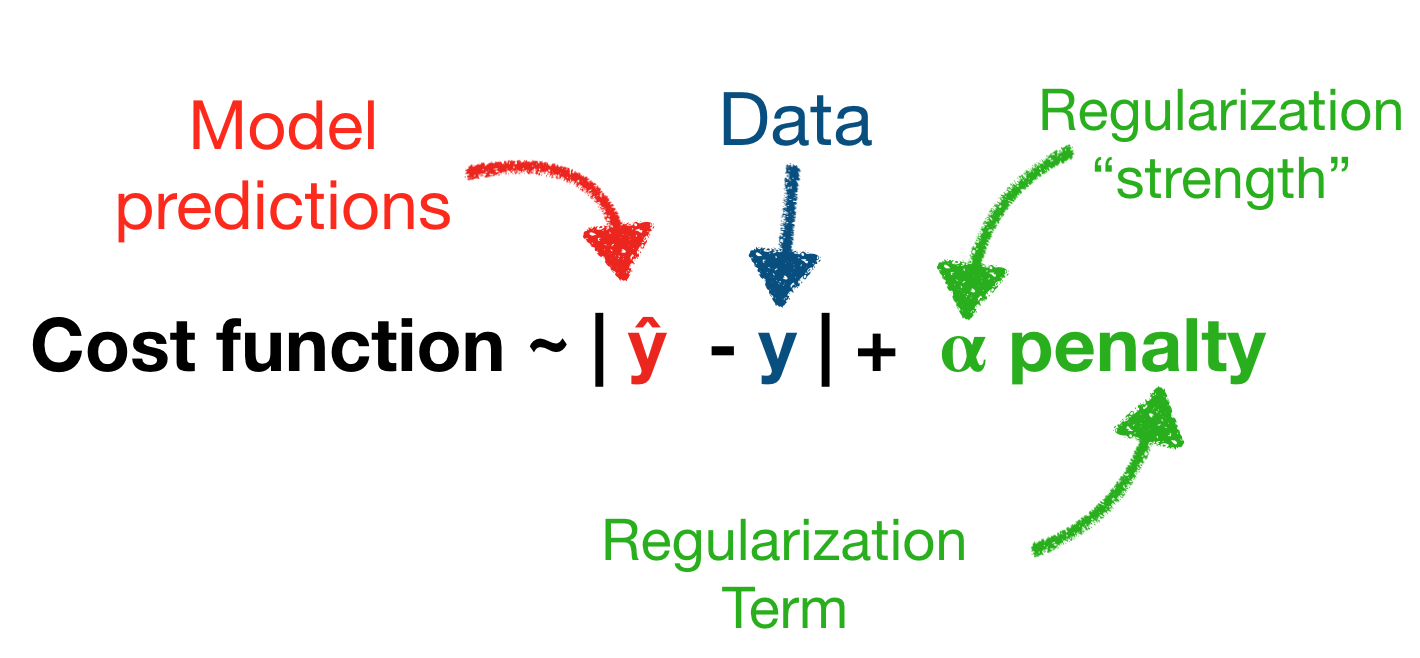

##  Key question: How do we know if a model will perform well on new data?

<img src="https://media.giphy.com/media/3ohhwjIjLLWBh4EQRW/giphy.gif" width=600></img>

### Crossing your fingers and hoping for the best is not the recommended strategy

## Option #1: a train/test split

- Split your data into two sets: the *training set* and the *test set*
- Train on the training set and test on the test set!
- The accuracy on the test set provides a measure of how well your model generalizes

Common to use 80% of data for your training set and 20% for your test set

- Still run the risk that you've selected the best model parameters for this **specific** training/test combination
- For example: 
    - Does the model work best on a 80/20 split, a 60/40 split, 70/30? How to decide the test/train split?
    - If you are using regularization, did your regularization strength parameter work only on this specific training set?

## Option #2: *k*-fold cross-validation

1. Break the data into a training set and test set
1. Split the training set into *k* subsets (or folds), holding out one subset as the test set
1. Run the learning algorithm on each combination of subsets, using the average of all of the runs to find the best fitting model parameters

For more information, see the [scikit-learn docs](https://scikit-learn.org/stable/modules/cross_validation.html)

<img src=attachment:grid_search_cross_validation.png width=600></img>
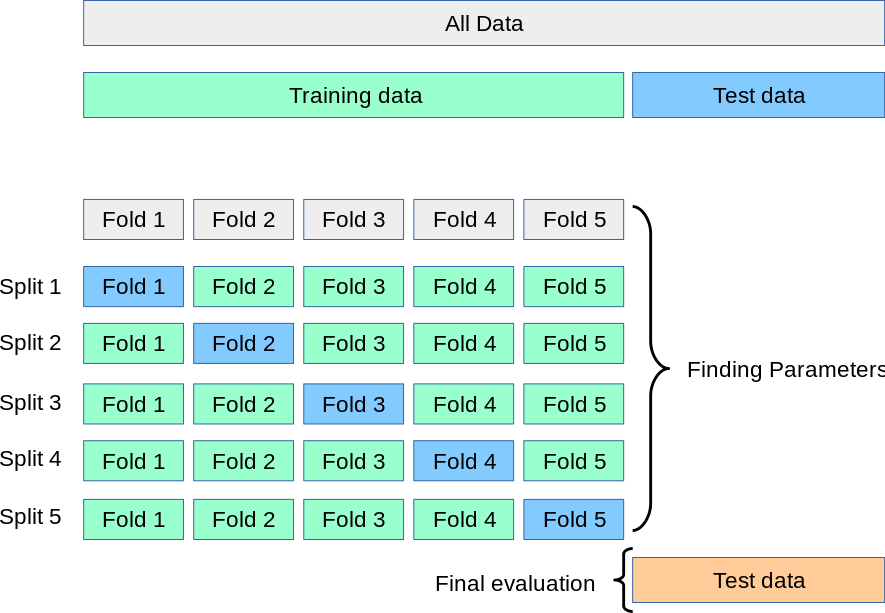

## Let's try out a simple example: does money make people happier?

We'll load data compiled from two data sources:
- The *Better Life Index* from the [OECD's website](https://stats.oecd.org/index.aspx?DataSetCode=BLI)
- GDP per capita from the [IMF's website](https://www.imf.org/external/pubs/ft/weo/2016/01/weodata/weorept.aspx?pr.x=32&pr.y=8&sy=2015&ey=2015&scsm=1&ssd=1&sort=country&ds=.&br=1&c=512,668,914,672,612,946,614,137,311,962,213,674,911,676,193,548,122,556,912,678,313,181,419,867,513,682,316,684,913,273,124,868,339,921,638,948,514,943,218,686,963,688,616,518,223,728,516,558,918,138,748,196,618,278,624,692,522,694,622,142,156,449,626,564,628,565,228,283,924,853,233,288,632,293,636,566,634,964,238,182,662,453,960,968,423,922,935,714,128,862,611,135,321,716,243,456,248,722,469,942,253,718,642,724,643,576,939,936,644,961,819,813,172,199,132,733,646,184,648,524,915,361,134,362,652,364,174,732,328,366,258,734,656,144,654,146,336,463,263,528,268,923,532,738,944,578,176,537,534,742,536,866,429,369,433,744,178,186,436,925,136,869,343,746,158,926,439,466,916,112,664,111,826,298,542,927,967,846,443,299,917,582,544,474,941,754,446,698,666&s=NGDPDPC&grp=0&a)

In [20]:
data = pd.read_csv("./data/gdp_vs_satisfaction.csv")
data.head()

Country  life_satisfaction  gdp_per_capita
0  Australia                7.3        50961.87
1    Austria                7.1        43724.03
2    Belgium                6.9        40106.63
3     Brazil                6.4         8670.00
4     Canada                7.4        43331.96

## Make a quick plot



In [21]:
import hvplot.pandas

In [22]:
data.hvplot.scatter(
    x="gdp_per_capita",
    y="life_satisfaction",
    hover_cols=["Country"],
    ylim=(4, 9),
    xlim=(1e3, 1.1e5),
)

:Scatter   [gdp_per_capita]   (life_satisfaction,Country)

## There's a roughly linear trend here...let's start there

<img src=attachment:Screen%20Shot%202019-11-13%20at%208.19.26%20PM.png width=600></img>

A simple model with only two parameters: $\theta_1$ and $\theta_2$
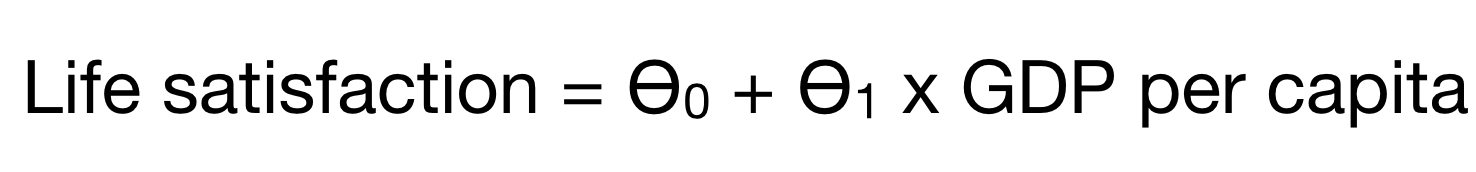

Use the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model object from scikit-learn.

This is not *really* machine learning — it simply finds the [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) fit to the data.

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
model = LinearRegression()
model

LinearRegression()

In [25]:
# Our input features (in this case we only have 1)
X = data['gdp_per_capita'].values
X = X[:, np.newaxis]

# The labels (values we are trying to predict)
y = data['life_satisfaction'].values

In [26]:
X.shape

(40, 1)

In [27]:
y.shape

(40,)

**Note:** scikit learn expects the features to be a 2D array with shape: `(number of observations, number of features)`. 

We are explicitly adding a second axis with the `np.newaxis` variable.

Now, fit the model using the `model.fit(X, y)` syntax. 

This will "train" our model, using an optimization algorithm to identify the bestfit parameters.

In [28]:
model.fit(X, y)

LinearRegression()

In [29]:
intercept = model.intercept_
slope = model.coef_[0]

print(f"bestfit intercept = {intercept:.2f}")
print(f"bestfit slope = {slope:.2e}")

bestfit intercept = 5.72
bestfit slope = 2.47e-05


## Reminder: What's with the "_" at the end of variable names?

These represent "estimated" properties of the model — this is how scikit learn signals to the user that these attributes depend on the `fit()` function being called beforehand.

More info [here](https://scikit-learn.org/dev/developers/develop.html#estimated-attributes).

**Note:** In this case, our model is the same as ordinary least squares, and no actually optimization is performed since an exact solution exists.

## How good is the fit?

- Each scikit learn model has a built-in `score()` function that provides a score to evaluate the fit by.
- In the case of the linear model, the score is the $R^2$ coefficient of the fit

**Note:** you must call the `fit()` function before calling the `score()` function.

In [30]:
Rsq = model.score(X, y)
Rsq

0.519153782362894

## Let's plot the data and the predicted values

Use the `predict()` function to predict new values.

In [31]:
# The values we want to predict (ranging from our min to max GDP per capita)
gdp_pred = np.linspace(1e3, 1.1e5, 100)

# Sklearn needs the second axis!
X_pred = gdp_pred[:, np.newaxis]

y_pred = model.predict(X_pred)

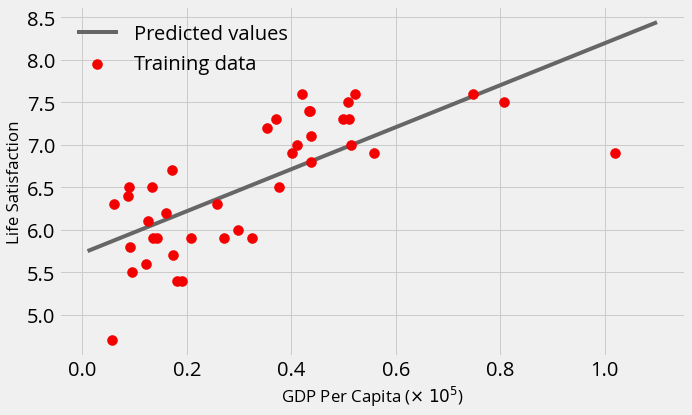

In [32]:
with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the predicted values
    ax.plot(X_pred / 1e5, y_pred, label="Predicted values", color="#666666")

    # Training data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Training data",
        s=100,
        zorder=10,
        color="#f40000",
    )

    ax.legend()
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")

## Not bad....but what did we do wrong?



<img src=https://media.giphy.com/media/1Bh2zyW2yuBEalV0rO/giphy.gif width=500></img>

### 1. We also fit and evaluated our model on the same training set!

### 2. We didn't scale our input data features!

Scikit learn provides a utility function to split our input data:

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# I'll use a 70/30% split
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

These are new DataFrame objects, with lengths determined by the split percentage:

In [35]:
print("size of full dataset = ", len(data))
print("size of training dataset = ", len(train_set))
print("size of test dataset = ", len(test_set))

size of full dataset =  40
size of training dataset =  28
size of test dataset =  12


Now, make our feature and label arrays:

In [36]:
# Features
X_train = train_set['gdp_per_capita'].values
X_train = X_train[:, np.newaxis]

X_test = test_set['gdp_per_capita'].values
X_test = X_test[:, np.newaxis]

# Labels
y_train = train_set['life_satisfaction'].values
y_test = test_set['life_satisfaction'].values

Use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the GDP per capita:

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()

In [39]:
# Scale the training features
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test features
X_test_scaled = scaler.fit_transform(X_test)

Now, let's fit on the *training set* and evaluate on the *test set*

In [40]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [41]:
model.score(X_test_scaled, y_test)

0.3595958514715957

**Unsurprisingly, our fit gets worst when we test on unseen data**

Our accuracy was artifically inflated the first time, since we trained and tested on the same data.

## Can we do better? Let's do some feature engineering...

We'll use scikit learn's [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to add new polynomial features from the GDP per capita.

In [42]:
from sklearn.preprocessing import PolynomialFeatures

### Let's try up to degree 3 polynomials ($x^3$)

In [43]:
poly = PolynomialFeatures(degree=3)

## Now we have two transformations to make:

1. Scale our features
1. Create the polynomial features

In [44]:
# Training
X_train_scaled_poly = poly.fit_transform(scaler.fit_transform(X_train))

# Test
X_test_scaled_poly = poly.fit_transform(scaler.fit_transform(X_test))

In [45]:
X_train.shape

(28, 1)

In [46]:
X_train_scaled_poly.shape

(28, 4)

In [47]:
model.fit(X_train_scaled_poly, y_train)

LinearRegression()

In [48]:
model.score(X_test_scaled_poly, y_test)

0.5597457659851048

**The accuracy improved!**

## Pipelines: making multiple transformations *much* easier

We can turn our preprocessing steps into a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) object using the [`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) function.

In [49]:
from sklearn.pipeline import make_pipeline

In [50]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3))

pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3))])

Individual steps can be accessed via their names in a dict-like fashion:

In [51]:
# Step 1
pipe['standardscaler']

StandardScaler()

In [52]:
# Step 2
pipe['polynomialfeatures']

PolynomialFeatures(degree=3)

Let's apply this pipeline to our predicted GDP values for our plot:

In [53]:
y_pred = model.predict(pipe.fit_transform(X_pred))

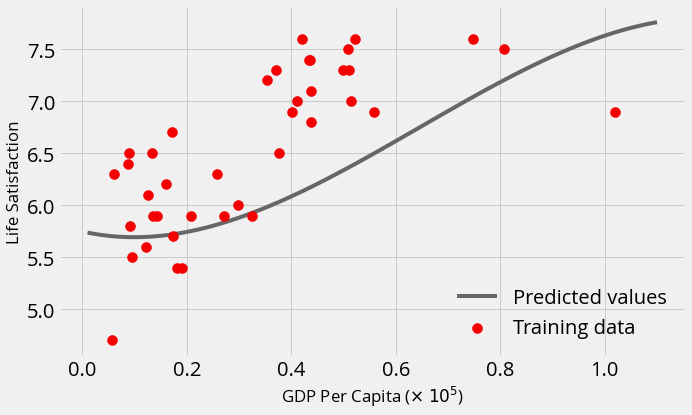

In [54]:
with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the predicted values
    y_pred = model.predict(pipe.fit_transform(X_pred))
    ax.plot(X_pred / 1e5 , y_pred, label="Predicted values", color="#666666")

    # Training data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Training data",
        s=100,
        zorder=10,
        color="#f40000",
    )

    ax.legend()
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")

**The additional polynomial features introduced some curvature and improved the fit!**

## How about large polynomial degrees?

degree = 3
Training Score = 0.6458898101593082
Test Score = 0.5597457659851048

degree = 5
Training Score = 0.6846206186564372
Test Score = -3.94657525455514

degree = 10
Training Score = 0.8020213670053926
Test Score = -26330.208557019356



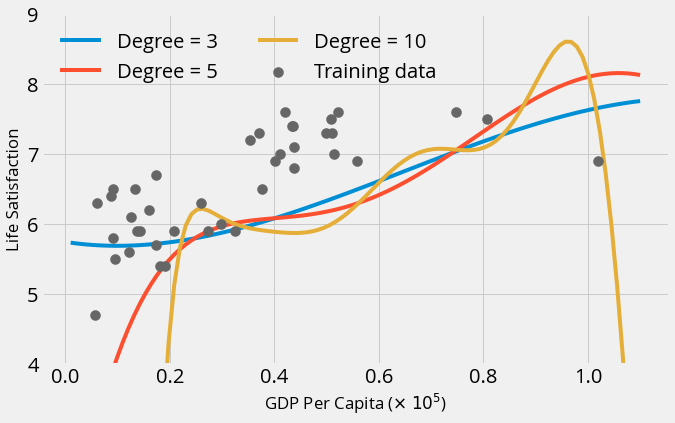

In [55]:
with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Original data set
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Training data",
        s=100,
        zorder=10,
        color="#666666",
    )
    
    # Plot the predicted values
    for degree in [3, 5, 10]:
        print(f"degree = {degree}")
        
        # Create out pipeline
        p = make_pipeline(StandardScaler(), PolynomialFeatures(degree=degree))
        
        # Fit the model on the training set
        model.fit(p.fit_transform(X_train), y_train)
        
        # Evaluate on the training set
        training_score = model.score(p.fit_transform(X_train), y_train)
        print(f"Training Score = {training_score}")
        
        # Evaluate on the test set
        test_score = model.score(p.fit_transform(X_test), y_test)
        print(f"Test Score = {test_score}")
        
        # Plot
        y_pred = model.predict(p.fit_transform(X_pred))
        ax.plot(X_pred / 1e5, y_pred, label=f"Degree = {degree}")
        
        print()

    ax.legend(ncol=2, loc=0)
    ax.set_ylim(4, 9)
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")

## Overfitting alert!

As we increase the polynomial degree, two things happen:

1. Training accuracy goes way up 
1. Test accuracy goes way down
    
This is the classic case of overfitting — our model does not generalize well at all.

## Regularization to the rescue?

- The [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) adds regularization to the linear regression least squares model
- Parameter $\alpha$ determines the level of regularization
- Larger values of $\alpha$ mean stronger regularization — results in a "simpler" bestfit

**Remember, regularization penalizes large parameter values and complex fits**